# Comparison between Spatial Signatures and GHSL classes

In [1]:
import pandas
import geopandas
import rasterio
import rioxarray
import xrspatial
import contextily
import dask_geopandas
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from shapely.geometry import box
from rasterstats import zonal_stats
from dask.array import unique as daunique

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


Dask setup (used in a few instances below):

In [35]:
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster())
client

2022-07-15 20:54:26,814 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/spatial_signatures/clusters/dask-worker-space/worker-hrnp4rum', purging
2022-07-15 20:54:26,814 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/spatial_signatures/clusters/dask-worker-space/worker-v9seiwgx', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41089,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.49 GiB
Comm: tcp://127.0.0.1:42371,Total threads: 4
Dashboard: http://127.0.0.1:41209/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:40121,


In [ ]:
client.restart()

## Global GHSL


### Read data

Global file downloaded originally from [here](https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_BUILT_C_GLOBE_R2022A/GHS_BUILT_C_MSZ_GLOBE_R2022A/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10/V1-0/).

In [36]:
ghsl_path = (
    '/home/jovyan/data/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.tif'
)
ghsl = rasterio.open(ghsl_path)

In [37]:
ghsl = rioxarray.open_rasterio(
    ghsl_path, chunks=11000, cache=False
)

In [38]:
ghsl

,Array,Chunk
Bytes,5.91 TiB,115.39 MiB
Shape,"(1, 1800000, 3608200)","(1, 11000, 11000)"
Count,53957 Tasks,53956 Chunks
Type,uint8,numpy.ndarray


### Parse colors

Read and parse the color file:

In [39]:
def parse_clr(p):
    with open(p) as fo:
        lines = fo.readlines()
    colors = pandas.DataFrame(
        map(parse_line, lines),
        columns=['code', 'color', 'name']
    )
    return colors
def parse_line(l):
    l = l.replace('\n', '').split(' ')
    code = l[0]
    rgba = tuple(map(int, l[1:5]))
    name = ' '.join(l[5:])
    return code, rgba, name
colors = parse_clr(
    '/home/jovyan/data/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0/'
    'GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0.clr'
)

### Explore values

For the GB extent:

- [x] What are the unique values appearing in the dataset (i.e., make sure I'm not missing anyone I don't have now)
- [x] Proportions of pixels by value (*what classes are more common?*)
- [ ] Zoom into a few cities (e.g., London, Liverpool, Glasgow)

- GB extent (hardcoded as file not read yet)

In [7]:
gb_bb = gb_minx, gb_miny, gb_maxx, gb_maxy = (
    -583715.9369692 , 5859449.59340008,  129491.84447583, 6958662.59197899
)

- GB subset

In [8]:
ghsl_gb = ghsl.sel(
    x = slice(gb_minx, gb_maxx), y = slice(gb_maxy, gb_miny), band = 1
)

- Unique values

We can run the set of unique values present in the GB extent.

In [9]:
%%time
ghsl_class_values = daunique(ghsl_gb.data).compute()
ghsl_class_values

CPU times: user 2.22 s, sys: 238 ms, total: 2.45 s
Wall time: 20.5 s


array([  0,   1,   2,   3,   4,   5,  11,  12,  13,  14,  15,  21,  22,
        23,  24,  25, 255], dtype=uint8)

This shows that, compared to the color files (parsed above), there are only two additional values present in the dataset: `0`, which we later name as "Other" (although it is unclear what it represents); and `255`, which is the value for missing data/`NaN`.

- Proportions

Now we are interested in knowing how prevalent each class/value is acros GB.

In [13]:
%%time
proportions = xrspatial.zonal.stats(
    zones=ghsl_gb, values=ghsl_gb, stats_funcs=['count']
).compute()
proportions

/opt/conda/lib/python3.9/site-packages/dask/dataframe/multi.py:1254: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(
2022-07-15 12:34:44,369 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 9.51 GiB -- Worker memory limit: 15.62 GiB
2022-07-15 12:35:27,302 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 10.62 GiB -- Worker memory limit: 15.62 GiB


CPU times: user 1min 14s, sys: 6.03 s, total: 1min 20s
Wall time: 4min 59s


,zone,count
0,0,5.602494e+09
1,1,7.034046e+06
2,2,2.815456e+07
3,3,6.134572e+07
4,4,5.850830e+05
5,5,5.812731e+06
6,11,3.165273e+07
7,12,1.810498e+07
8,13,3.299108e+07
9,14,9.017500e+05


Now build a crosswalk for the names:

In [33]:
cw = colors.set_index('code').rename(int)['name']
cw.loc[0] = 'Other'
cw.loc[255] = 'N/A'

And display in a bar plot:

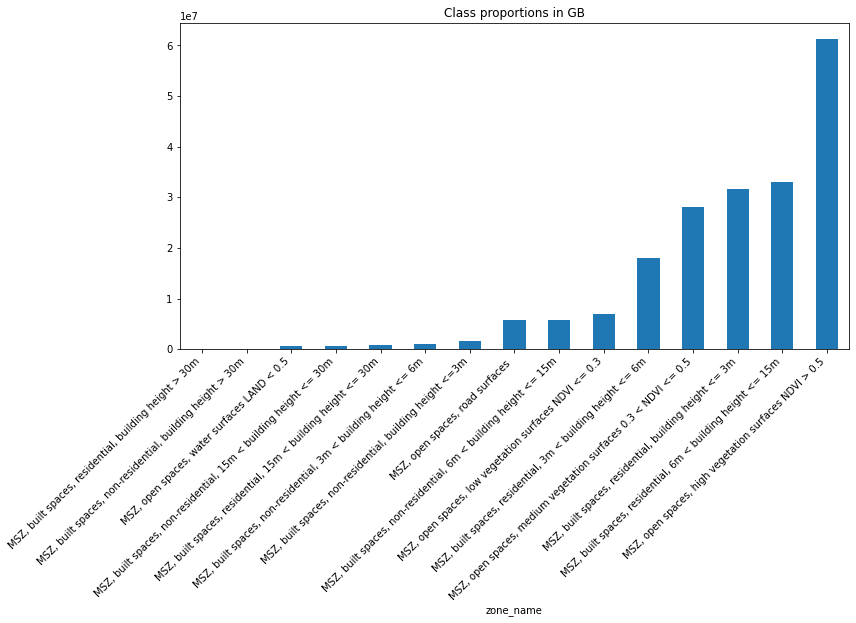

In [44]:
proportions.assign(
    zone_name=proportions['zone'].map(cw)
).set_index(
    'zone_name'
).sort_values(
    'count'
).drop(
    ['N/A', 'Other']
)['count'].plot.bar(
    figsize=(12, 6), title='Class proportions in GB'
)
plt.xticks(
    rotation=45,
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium',
);

- Visualisations

In [83]:
geolocator = Nominatim(user_agent="dab_research").geocode

def name2poly(name):
    loc = geolocator(name)
    miny, maxy, minx, maxx = tuple(map(float, loc.raw['boundingbox']))
    poly = geopandas.GeoSeries([box(minx, miny, maxx, maxy)], crs='EPSG:4326')
    return poly

Let's manually get extents for a few cities:

In [102]:
city_names = ['London', 'Liverpool', 'Glasgow']
cities = geopandas.GeoSeries(
    pandas.concat([name2poly(city) for city in city_names]).values, index=city_names,
).to_crs(ghsl.rio.crs)
cities

London       POLYGON ((24970.789 6007550.107, 24830.971 604...
Liverpool    POLYGON ((-205855.227 6209162.864, -204877.117...
Glasgow      POLYGON ((-286155.194 6456752.478, -284662.788...
dtype: geometry

In [117]:
minx, miny, maxx, maxy = bb = cities.loc['Liverpool'].bounds
liv = ghsl_gb.sel(
    x=slice(minx, maxx), y=slice(maxy, miny)
)

**TO BE FINISHED**

## Spatial Signatures

### Read data

We use the officially released file with all detail (and a larger footprint) is available from the Figshare repository [here](https://figshare.com/articles/dataset/Geographical_Characterisation_of_British_Urban_Form_and_Function_using_the_Spatial_Signatures_Framework/16691575/2?file=36049196).

In [8]:
ss = geopandas.read_file(
    '/home/jovyan/data/spatial_signatures/'
    'spatial_signatures_GB.gpkg'
).to_crs(ghsl.rio.crs)

Build list of types to turn them into ints:

In [9]:
types = {i: j[1]['type'] for i, j in enumerate(
    ss[['code', 'type']].drop_duplicates().iterrows()
)}
types_r = {types[i]: i for i in types}
types

{0: 'Countryside agriculture',
 1: 'Accessible suburbia',
 2: 'Open sprawl',
 3: 'Wild countryside',
 4: 'Warehouse/Park land',
 5: 'Gridded residential quarters',
 6: 'Urban buffer',
 7: 'Disconnected suburbia',
 8: 'Dense residential neighbourhoods',
 9: 'Connected residential neighbourhoods',
 10: 'Dense urban neighbourhoods',
 11: 'Local urbanity',
 12: 'Concentrated urbanity',
 13: 'Regional urbanity',
 14: 'outlier',
 15: 'Metropolitan urbanity',
 16: 'Hyper concentrated urbanity'}

Add column with class int:

In [10]:
ss['code_no'] = ss['type'].map(types_r)

### Explore areas

Calculate the area

In [11]:
ss['area'] = ss.area

The distribution is heavily skewed, with five polygons above `1e10`. Kicking out ten polygons gets the largest area within 0.5 * `1e10`:

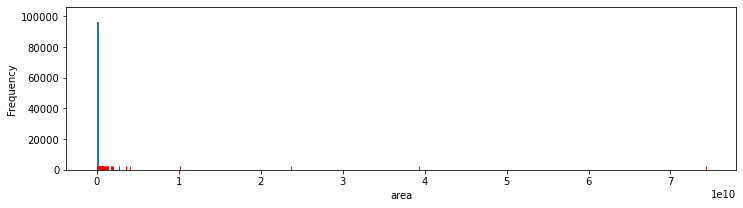

In [10]:
ax0 = ss['area'].plot.hist(bins=300, figsize=(12, 3))
sns.rugplot(ss['area'], color='r', alpha=1, ax=ax0);

Subset to remove the largest ten signatures:

In [11]:
sub = ss.sort_values(
    'area', ascending=False
).iloc[10:, :]

They all belong in the least urban classes:

In [12]:
ss.sort_values(
    'area', ascending=False
).head(10)['type'].unique()

array(['Countryside agriculture', 'Wild countryside', 'Urban buffer'],
      dtype=object)

We can now explore the largest remaining polygons:

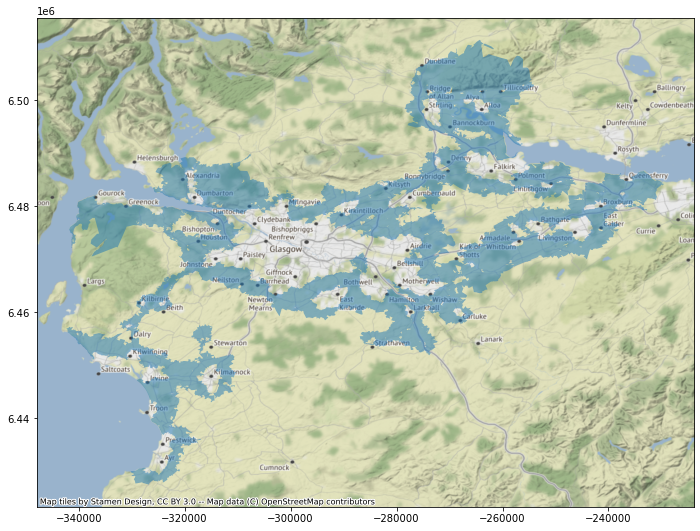

In [13]:
ax = sub.head(1).plot(alpha=0.5, figsize=(12, 9))
contextily.add_basemap(ax, crs=sub.crs);

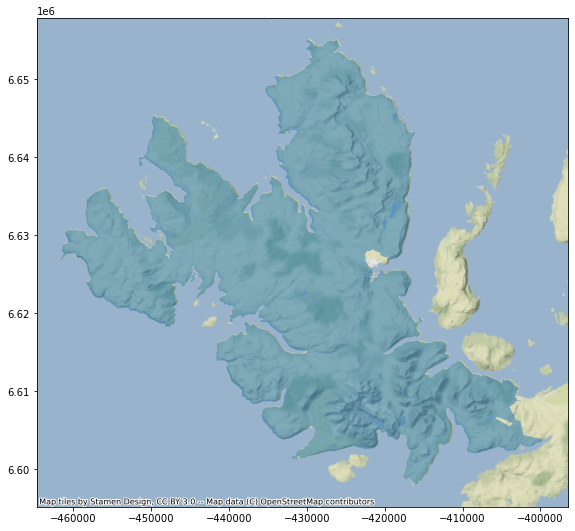

In [14]:
ax = sub.iloc[[1], :].plot(alpha=0.5, figsize=(12, 9))
contextily.add_basemap(ax, crs=sub.crs);

**CONCLUSION** - A pragmatic approach is to remove the ten largest signature polygons and run on Dask zonal stats, then process individually, with all memory dedicated to each job, each of the remaining ones, and finally merge the set.

## Overlap

The strategy to obtain the overlap on all signature polygons is the following:

- [ ] Run on Dask overlap for all but the largest ten areas in small partitions
- [ ] For larger polygons:
     - [ ] Split polygon into smaller ones by overlaying a grid of a given size (`griddify`)
     - [ ] Assign IDs that allow to reconstruct zonal stats
     - [ ] Run on Dask
     - [ ] Collect and aggregate at the original signature level
- [ ] Merge all area overlap into a single table
- [ ] Reindex to align with `ss`
- [ ] Write down to file

### Smaller areas

Move signatures to Dask:

In [16]:
ss_ddf = dask_geopandas.from_geopandas(
    ss.sort_values('area').iloc[:-10, :], 
    chunksize=1000
)

Preliminaries. We get the names as `category_map` so the output is expressed with class names from GHSL. It is important to note that there is an additional category that does not appear in the color file, `0`, which we name as "Other".

In [40]:
category_map = colors.assign(code=colors['code'].astype(int)).set_index('code')['name'].to_dict()
category_map[0] = 'Other'

def do_zonal_stats(df):
    out = zonal_stats(
        df, 
        ghsl_path, 
        categorical=True,
        category_map=category_map,
        all_touched=True
    )
    out = pandas.DataFrame(out).reindex(
        columns=category_map.values()
    )
    out['id'] = df['id'].values
    return out

meta = {c: 'str' for c in category_map.values()}
meta['id'] = 'str'

Build computation graph for all but the largest areas:

In [ ]:
tmp = ss_ddf.map_partitions(
    do_zonal_stats,
    meta=meta
)

Execute on Dask cluster:

In [ ]:
%%time
out = tmp.compute()
out.to_parquet('/home/jovyan/data/spatial_signatures/ghsl_proportions.pq')

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


### Largest areas

Method to split up a polygon into chunks by overlaying a grid with either `cells` cells, or cells of `side` side:

In [12]:
def griddify(poly, side=None, cells=None, pid=None, crs=None):
    minx, miny, maxx, maxy = poly.bounds
    if side is not None:
        xs = np.arange(minx, maxx+side, side)
        ys = np.arange(miny, maxy+side, side)
    elif cells is not None:
        xs = np.linspace(minx, maxx, cells)
        ys = np.linspace(miny, maxy, cells)
    else:
        raise Exception(
            "Please make either `side` or `cells` not None"
        ) 
    geoms = []
    for i in range(len(xs)-1):
        for j in range(len(ys)-1):
            geoms.append(box(xs[i], ys[j], xs[i+1], ys[j+1]))
    grid = geopandas.GeoDataFrame(
        {'geometry': geoms, 'subdivision': np.arange(len(geoms))},
        crs=crs
    )
    if pid is not None:
        grid['sid'] = pid
    grid = geopandas.overlay(
        grid, geopandas.GeoDataFrame({'geometry':[poly]}, crs=crs)
    )
    return grid

Pick the largest ten that have not been already processed:

In [13]:
largest = ss.sort_values('area').tail(10)

Subdivide them into smaller chunks that can be easily processed in Dask:

In [30]:
%%time
subdivided = pandas.concat(
    largest.apply(
        lambda r: griddify(r['geometry'], side=10000, pid=r['id'], crs=ss.crs), 
        axis=1
    ).tolist()
)

CPU times: user 7min 10s, sys: 15.6 ms, total: 7min 10s
Wall time: 7min 10s


Ship subdivided to Dask and build computation graph:

In [61]:
client.restart()

2022-07-15 21:15:20,581 - distributed.nanny - WARNING - Restarting worker
2022-07-15 21:15:20,583 - distributed.nanny - WARNING - Restarting worker
2022-07-15 21:15:20,584 - distributed.nanny - WARNING - Restarting worker
2022-07-15 21:15:20,813 - distributed.nanny - WARNING - Restarting worker


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.49 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41089,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 20 minutes ago,Total memory: 62.49 GiB
Comm: tcp://127.0.0.1:37407,Total threads: 4
Dashboard: http://127.0.0.1:36699/status,Memory: 15.62 GiB
Nanny: tcp://127.0.0.1:40121,


In [62]:
subdivided['id'] = subdivided['subdivision'].astype(str) + '-' + subdivided['sid']

largest_ddf = dask_geopandas.from_geopandas(subdivided, chunksize=100)
tmp = largest_ddf.map_partitions(do_zonal_stats, meta=meta)

Run computation on Dask cluster:

In [63]:
%%time
subdivided_stats = tmp.compute()

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
/opt/conda/lib/python3.9/site-packages/geopandas/_vectorized.py:153: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/opt/conda/lib/python3.9/site-packages/geopandas/_vectorized.py:153: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/opt/con

CPU times: user 25.9 s, sys: 2.34 s, total: 28.2 s
Wall time: 1min 46s


Aggregate at signature level by adding up values in each signature:

In [69]:
subdivided_stats['sid'] = subdivided_stats['id'].map(lambda i: i.split('-')[1])
largest_stats = subdivided_stats.groupby('sid').sum().reset_index()
largest_stats

,sid,"MSZ, open spaces, low vegetation surfaces NDVI <= 0.3","MSZ, open spaces, medium vegetation surfaces 0.3 < NDVI <= 0.5","MSZ, open spaces, high vegetation surfaces NDVI > 0.5","MSZ, open spaces, water surfaces LAND < 0.5","MSZ, open spaces, road surfaces","MSZ, built spaces, residential, building height <= 3m","MSZ, built spaces, residential, 3m < building height <= 6m","MSZ, built spaces, residential, 6m < building height <= 15m","MSZ, built spaces, residential, 15m < building height <= 30m","MSZ, built spaces, residential, building height > 30m","MSZ, built spaces, non-residential, building height <=3m","MSZ, built spaces, non-residential, 3m < building height <= 6m","MSZ, built spaces, non-residential, 6m < building height <= 15m","MSZ, built spaces, non-residential, 15m < building height <= 30m","MSZ, built spaces, non-residential, building height > 30m",Other
0,39193_WIC,1138.0,4695.0,29653.0,293.0,2680.0,39921.0,0.0,0.0,0.0,0.0,657.0,0.0,0.0,0.0,0.0,19118831.0
1,39251_WIC,23390.0,162111.0,527781.0,7478.0,40714.0,786886.0,3065.0,1320.0,120.0,0.0,32795.0,1629.0,1142.0,1245.0,0.0,392963527.0
2,39497_WIC,4663.0,35640.0,432333.0,1277.0,24170.0,554649.0,7900.0,1061.0,0.0,0.0,14591.0,890.0,1118.0,0.0,0.0,100484844.0
3,39729_WIC,9172.0,100903.0,705946.0,7632.0,40268.0,857290.0,67438.0,5778.0,0.0,0.0,80755.0,7440.0,2076.0,0.0,0.0,236194274.0
4,459_COA,176010.0,1790322.0,10428891.0,57371.0,582534.0,10768204.0,1778848.0,299119.0,14779.0,964.0,611600.0,153111.0,286784.0,32264.0,3387.0,719705569.0
5,479_COA,5625.0,53297.0,165588.0,3346.0,16150.0,171664.0,68041.0,11930.0,152.0,73.0,15540.0,8060.0,8330.0,161.0,387.0,17453666.0
6,583_COA,6937.0,71197.0,208668.0,2547.0,18409.0,266114.0,15827.0,4480.0,657.0,0.0,24492.0,2896.0,2446.0,800.0,0.0,26316439.0
7,60230_URB,51906.0,302911.0,501268.0,6821.0,57306.0,383084.0,283760.0,168444.0,2876.0,0.0,15713.0,20852.0,48599.0,8086.0,0.0,16541750.0
8,63883_URB,125007.0,797047.0,1543231.0,21005.0,139818.0,772403.0,959215.0,566485.0,3029.0,86.0,65965.0,83668.0,215883.0,5875.0,636.0,36155195.0
9,66140_URB,83158.0,546579.0,1911597.0,11646.0,126916.0,835693.0,1073994.0,382943.0,3408.0,184.0,44970.0,52928.0,109235.0,4767.0,0.0,30507595.0


### Merge areas and write out

In [73]:
smallest_stats = pandas.read_parquet(
    '/home/jovyan/data/spatial_signatures/ghsl_proportions.pq'
).rename(columns={'id': 'sid'})

In [74]:
all_stats = pandas.concat([smallest_stats, largest_stats])

In [80]:
ss.join(
    all_stats.set_index('sid'), on='id'
).to_parquet(
    '/home/jovyan/data/spatial_signatures/ghsl_proportion_stats.pq'
)

/tmp/ipykernel_605681/1151739440.py:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  ss.join(


## Comparison

---

---

## **DEPRECATED**

As of July 13th'22, the approaches below are deprecated because loading imagery for certain signature polygons is deemed unfeasible. The main issue is there are a few very large polygons:

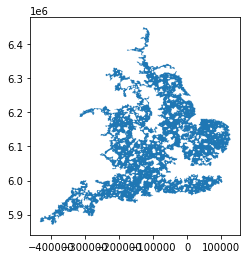

In [27]:
ssa = ss.area
ss[ssa == ssa.max()].plot();

- Single-core approach

In [64]:
%%time
stats = pandas.DataFrame(
    zonal_stats(ss.head(100), ghsl_path, categorical=True),
).reindex(columns=colors['code'].astype(int))

CPU times: user 3.14 s, sys: 15.1 s, total: 18.3 s
Wall time: 18.1 s


---

### Signature rasterisation

Following similar procedures (e.g., [here](validation)), we rasterise the signatures.

In [ ]:
%%time
rss = make_geocube(
    ss, 
    measurements=['code_no'], 
    like=ghsl.rio.clip_box(*ss.total_bounds)
)

In [10]:
rss

<xarray.Dataset>
Dimensions:      (y: 109923, x: 71322)
Coordinates:
  * y            (y) float64 6.959e+06 6.959e+06 ... 5.859e+06 5.859e+06
  * x            (x) float64 -5.837e+05 -5.837e+05 ... 1.295e+05 1.295e+05
    spatial_ref  int64 0
Data variables:
    *empty*

In [29]:
ghsl.rio.clip_box(*ss.total_bounds)

<xarray.DataArray (band: 1, y: 109923, x: 71322)>
dask.array<getitem, shape=(1, 109923, 71322), dtype=uint8, chunksize=(1, 11000, 11000), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -5.837e+05 -5.837e+05 ... 1.295e+05 1.295e+05
  * y            (y) float64 6.959e+06 6.959e+06 ... 5.859e+06 5.859e+06
    spatial_ref  int64 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0
    _FillValue:    255